## MF4056 Assignment 2

#### Ben McEnery 120411954

#### Diana Kustova 120471454

In [1]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
from ipywidgets import interact
from IPython.display import display
import pandas as pd
from pandas.plotting import table
rng=np.random.default_rng()

# Question 1
##### (a)
The STochastic Differential Equation (SDE) of the Cox-Ingresol-Rox model takes the form:

$$ dS(t) = \kappa(\lambda - S(t))dt + \sigma \sqrt{S(t)}dB(t) , t \in [0,T], S_{0} > 0 $$

where $\kappa,\lambda, \sigma > 0$, and

$$ \mathbb{E} [S(t)] = S_0e^{-\kappa T} + \lambda\left(1-e^{-\kappa T}\right)  $$

In [8]:
# Define the parameters needed:
k = 1
lam = S0=Y0 = 0.2
sigma = 0.1
T = 1

In [9]:
# Create the function:
def ExpectedS(k, lam, sigma, T):
    return S0*m.exp(-k*T) + lam*(1-m.exp(-k*T))

# Apply fucntion to values given:
ExpectedS(1,0.5,0.1,1)

0.3896361676485673

##### (b)
Plot approximations of same single trajectory of of Cox-Ingersoll-Rox SDE using:

$(3)$ Explicit EUler-Maruyama method 
$$ S_{n+1} = S_n + h\kappa\left(\lambda - S_n\right) + \sigma \sqrt{|S_n|}\Delta B_{n+1}$$ 

where $\Delta B_{n+1} = \left((n+1)h\right) - B(nh)$ and valeus of $S(T)$ may be approximated by $S(T) \approx S_N$

$(5)$ Implicit Euler-Maruyama method under tansformaton of $Y(t) = \sqrt{S(T)}$
$$ Y_{k+1} = \frac{Y_k + \gamma\Delta B_{n+1}}{2(1-\beta h)} + \sqrt{\frac{\left(Y_k + \gamma\Delta B_{n+1}\right)^2}{4(1-\beta h)^2} + \frac{\alpha h}{1-\beta h)^2}}$$


where $\alpha = \frac{(4k\lambda - \sigma^2)}{8}$ , $\beta = \frac{-4k}{8}$ and $\gamma = \frac{\sigma}{2} $ and values of $S(T)$ may be approximated by computing $Y_N$ and then squaring: $S(T) \approx Y_{N}^2$

In [10]:
# Define the necessary parameters
T = 1
N = 2**3
h = T/N # using T as before


#simulate brownian motion
increments = rng.normal(0,m.sqrt(h),int(N)) # sample from centered normal, with variance h
B = np.cumsum(increments) #cummulative sum of increments
B = np.insert(B,0,0) # ensure inital condition for brownian motino is always 0

In [11]:

# define function that will plot both methods - given a sample brownian path (importnat for higher resolutiosns)
def plot_trajectories(k,lam, sigma, T, N, B):
    dt = T/N
    
    # method (3)
    
    # deinfe pa3ameters
    S_1 = np.zeros(N+1) # array for values of S
    S_1[0] = S0 # inital S set to first value of S array
    
    # apply explicit Euler-Maruyama method
    for i in range(0,N):
        S_1[i+1] = S_1[i] + dt*k*(lam-S_1[i]) + sigma*m.sqrt(abs(S_1[i]))*(B[i+1]-B[i])
        
    # method (5)  
    
    #define parameters
    alpha = (4*k*lam - sigma**2)/8
    beta = (-4*k)/8
    gamma = sigma/2
    Y = np.zeros(N+1)
    Y[0] = m.sqrt(S0)
    
    # apply method
    for i in range(0,N):
        Y[i+1] = (Y[i] + gamma*(B[i+1]-B[i]))/(2*(1-beta*dt)) + m.sqrt(((Y[i] + gamma*(B[i+1]-B[i]))**2)/(4*(1-beta*dt)) + alpha*dt/(1-beta*dt))
    
    #apply back-transformation for values of S
    S_5 = Y**2
    
    #plot both trajectories
    t = np.arange(0, T+dt, dt)
    plt.plot(t, S_1, label = "Explicit Method")
    plt.plot(t, S_5, label = "Implicit Method")
    plt.title(r'Sumulation of $S(t)$')
    plt.legend()


In [12]:
B1 = B # for reprodcibility

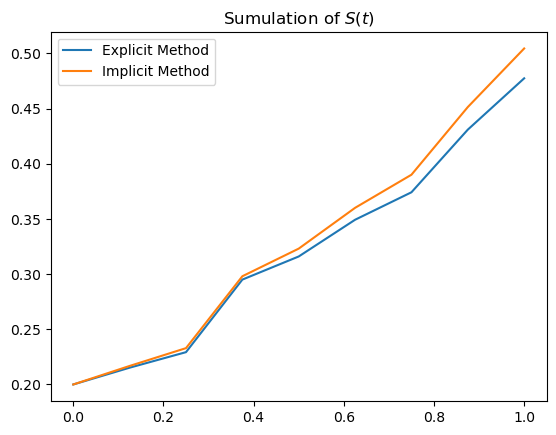

In [13]:
plot_trajectories(1,0.5,0.1,1, 8, B1)

###### Brownian Bridge
Since we want to compare the same trajectories at different resolutions, i.e. same starting and end points; we need to a brownian bridge to interpolate between the points. As per **Theorem 1.1** in *Notes 1*:
$$(W(t_2)|W(t_1) = x_1, W(t_3) = x_3) \sim \frac{(t_3-t_2)x_1 + (t_2-t_1)x_1}{(t_3-t_1} + \sqrt{\frac{(t_3-t_2)(t_2-t_1)}{(t_3-t_1)}}Z,$$

where $Z\sim \mathcal{N}(0,1)$ is a standard normal random variable that is independent of $W(t_1)\dots W(t_n)$|

In [14]:
# Define Brownian Bridge fucntion/
def b_bridge(t1,t,t2,x1,x2):
    Z = rng.normal(0,np.sqrt((t2-t)*(t-t1)/(t2-t1)),1)
    return ((t2-t)*x1+(t-t1)*x2)/(t2-t1)+Z

For $N = 2^7 = 128$, there wil be $128\div 8 = 16$ points needed in between each of the original $8$ points. Since the brownian bridge only interpolates between the points that we already have we will need to repeat the loop until $j\leq 16$ as we double $j$ at each iteration.

In [15]:
j = 2 # we want to double the iteration at each loop.
while j<=16: #16 extra points for each of the 8 in the original (8x16=128)
    B = np.insert(np.zeros(int((j/2)*N+1)),np.arange(int((j/2)*N+1)),B)
    B = np.delete(B, -1)
    h = T/(j*N)
    t = np.arange(0,T+h,h)
    
    for i in range(1,len(B),2):
        B[i] = b_bridge(t[i-1],t[i],t[i+1],B[i-1],B[i+1]);
    j = 2*j
    
    
    
B2 = B # for reprodicibiltiy 

The B array is now of size 128, so we can use this with original function to obatain a higher resolution plot 

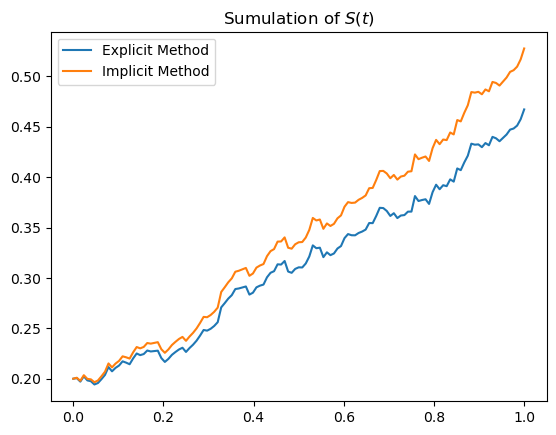

In [16]:
plot_trajectories(1,0.5,0.1,1, 2**7, B2)

Now repeat the same process, but for $N = 2^{10}$

In [17]:
j = 32 # we are increaseing by a factor of 2 each time; last iteration finishged at 16!
while j<=128: #128 extra points for each of the 8 in the original (128x8=1024)
    B = np.insert(np.zeros(int((j/2)*N+1)),np.arange(int((j/2)*N+1)),B)
    B = np.delete(B,-1)
    h = T/(j*N)
    t = np.arange(0,T+h,h)
    
    for i in range(1,len(B),2):
        B[i] = b_bridge(t[i-1],t[i],t[i+1],B[i-1],B[i+1]);
    j = 2*j
    
B3 = B

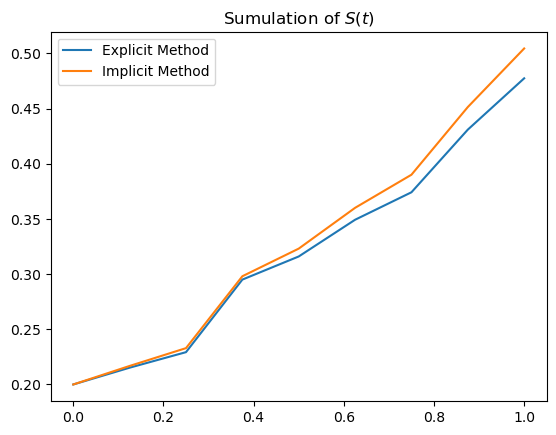

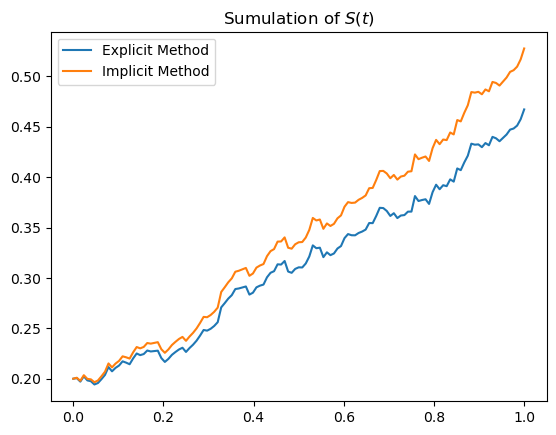

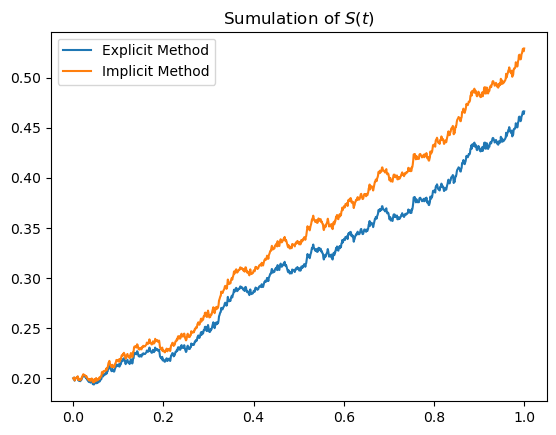

In [18]:
plt.show(plot_trajectories(1,0.5,0.1,1, 2**3, B1));
plt.show(plot_trajectories(1,0.5,0.1,1, 2**7, B2));
plt.show(plot_trajectories(1,0.5,0.1,1, 2**10, B3))

###### Comment
Cleary, as $N$ increases, the resolution both methods get better at capturing ths short term movements of $S(t)$, however it does come at a price. 

When $N = 2^3$ both methods seem to capture the general trend of the movements of $S(t)$, however they struggle to short term movements - indicated by the smooth lines. The trajectories of both methods are very similar, with only monor variations. This reslution may not capture the finest level of detail of the price movements, but it does offer the quickest run time.  

When $N = 2^7$, both the implicit, and the explicit method produce more realistic price paths for $S(t)$. Although the graphs are still somewhat smooth, they still exhibit noticeable volatility, with discernable peaks and troughs. The higher resolution captures the short term-movements of $S(t)$ 


When $N=2^{10}$ there is an improvement in the resolutoin of both graphs. This graph shows a high level of detail in the price trajectory. Both methods produce more fluctuations, accurately capturing the short-terem movements on an almost continous scale. However, this is more computationally expensive (see below for times). So there is a clear diminising return on the detail for both methods. 
 

Overall, both the explicit and the implicit method give very similiar trjectories. As time incereases the explicit method gives slightly lower values than the implicit. Most likely due to an explicit method accumulating the error over time, thus leading to a greater deviaton from the implicit method as time goes on. The implicit method generally tends to handle noise better and have better stability, making it the preferred method despite its' additional computational intensity

0.042498111724853516


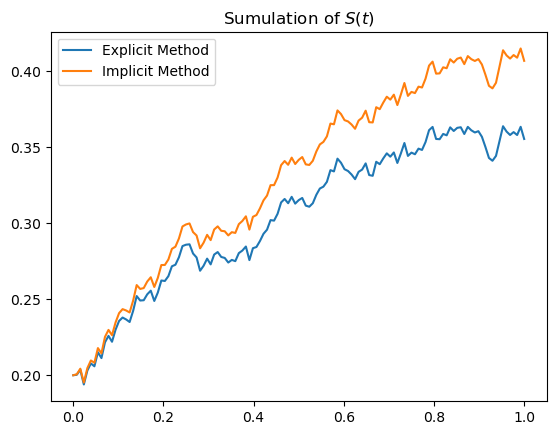

In [13]:
import time
start = time.time()
plot_trajectories(1,0.5,0.1,1, 2**7, B2) # process was repeated for B3, and results are recoded below
end  = time.time()
runtime = end-start
print(runtime)

When $N = 2^{10}$, the runtime is $0.031248092651367188$

When $N = 2^7$, the runtime is $0.0249021053314209$

Slightly lower for $N = 2^7$

#### (c) Table of Weak Errors
The weak error is taken as 
$$ |E[S(T)-E[S_N]]| $$ 

for the explicit method $(3)$, and 
$$ |E[S(T)-E[Y^2_N]]| $$

for the implicit method $(5)$

According to Higham's reviewe acrticle the use of multiple paths for each stepsize is "perfectly reasonable here as weak convergence concerns only the mean of the solutions," so we will need to simlute the trajetories again.

In [19]:
# Initialize an array to store weak errors
expliciterror = np.zeros((4, 3))



# Loop over different values of M and N
for j in range(2, 6):  # Iterating over 10^2 to 10^5 simulations
    M = 10 ** j
    Nvec = [3, 7, 10]
    for index, l in enumerate(Nvec):
        N = 2 ** l
        dt = T / N
        #using a vectorized approach for faster computation
        S = S0 * np.ones(M)  # Initial prices for all simulations
        for i in range(N):
            inc = np.sqrt(dt) * rng.normal(0, 1, M)
            S += dt * k * (lam - S) + sigma* np.sqrt(np.abs(S)) * inc

        # Calculate the weak error
        #average samples
        expected_S_N = np.mean(S)
        expected_S_T_val = ExpectedS(k, lam, sigma, T)
        expliciterror[j - 2, index] = abs(expected_S_N - expected_S_T_val)  


In [20]:
# fix issues with formatting
pd.set_option('display.precision', 10)  # 10 decimat places
pd.set_option('display.expand_frame_repr', False)  # Avoid wrapping to next line
pd.set_option('display.width', None)  # Auto-detect the display width

In [21]:
# Define the row and column labels for the error matrix
row_labels = [f"$M=10^2$", "$M=10^3$", "$M=10^4$", "$M=10^5$"]
column_labels = [f"$N=2^3$", "$N=2^7$", "$N =2^{10}$"]

# Create a DataFrame from the error matrix
explicitwe=pd.DataFrame(expliciterror, columns=column_labels, index=row_labels)
print("Weak errors for the explicit method:")
explicitwe


Weak errors for the explicit method:


,$N=2^3$,$N=2^7$,$N =2^{10}$
$M=10^2$,0.0009107336,0.0019755470,0.0040406478
$M=10^3$,0.0003669739,0.0002041776,0.0009275179
$M=10^4$,0.0002891633,0.0005598809,0.0005023341
$M=10^5$,0.0000581359,0.0000978875,0.0000294983


In [22]:
# Initialize an array to store weak errors
impliciterror = np.zeros((4, 3))

#define parameters
alpha = (4*k*lam - sigma**2)/8
beta = (-4*k)/8
gamma = sigma/2

# Loop over different values of M and N
for j in range(2, 6):  # Iterating over 10^2 to 10^5 simulations
    M = 10 ** j
    Nvec = [3, 7, 10]
    for index, l in enumerate(Nvec):
        N = 2 ** l
        dt = T / N
        #using a vectorized approach for faster computation
        Y = m.sqrt(Y0) * np.ones(M)  # Initial prices for all simulations
        for i in range(N):
            inc = np.sqrt(dt) * rng.normal(0, 1, int(M))
            Y = (Y+ gamma*inc)/(2*(1-beta*dt)) + np.sqrt((Y+gamma*inc)**2/(4*(1-beta*dt)**2) + alpha*dt/(1-beta*dt))

        # Calculate the weak error
        #average samples
        expected_Y_N = np.mean(Y**2)
        expected_Y_T_val = ExpectedS(k, lam, sigma, T)
        impliciterror[j - 2, index] = abs(expected_Y_N - expected_Y_T_val)  


In [23]:
implicitwe=pd.DataFrame(impliciterror, columns=column_labels, index=row_labels)
print("Weak errors for the implicit method:")
implicitwe


Weak errors for the implicit method:


,$N=2^3$,$N=2^7$,$N =2^{10}$
$M=10^2$,0.0027296003,0.0059939951,0.0054463225
$M=10^3$,0.0000841322,0.0005569404,0.0006395383
$M=10^4$,0.0001653817,0.0001194243,0.0005326502
$M=10^5$,0.0001624038,0.0000672306,0.0000666644


In [24]:
# interactive plot to see plot at different sample sizes
def interactive_S(Mrow=0):
    h = [T/2**3, T/2**7, T/2**10]
    plt.loglog(h,expliciterror[Mrow,:],label = "Explicit Method")
    plt.loglog(h,h,label = "Reference Line") # add reference line dt = dt
    plt.axhline(y = 10**-4,linestyle = '--', color = 'red') 
    plt.title("Plot of Errors for Explicit Method $(3)$") # add horizontal line for errror threshold
    plt.ylabel(r"$log(\mathcal{E}_h)$")
    plt.xlabel(r"$Dt$")
    plt.legend()
    plt.show()
    
plt.show(interact(interactive_S,Mrow=(0,3,1)))

interactive(children=(IntSlider(value=0, description='Mrow', max=3), Output()), _dom_classes=('widget-interact…

In [25]:
def interactive_Y(Mrow=0):
    h = [T/2**3, T/2**7, T/2**10]
    plt.loglog(h,impliciterror[Mrow,:],label = "Implicit Method")
    plt.loglog(h,h,label = "Reference Line")
    plt.axhline(y = 10**-4,linestyle = '--')
    plt.title("Plot of Errors for Explicit Method $(5)$")
    plt.ylabel(r"$log(\mathcal{E}_h)$")
    plt.xlabel(r"$Dt$")
    plt.legend()
    plt.show()
    
interact(interactive_S,Mrow=(0,3,1))

interactive(children=(IntSlider(value=0, description='Mrow', max=3), Output()), _dom_classes=('widget-interact…

<function __main__.interactive_S(Mrow=0)>

The goal is to have a slope that matches the reference line $(dt,dt)$ as the purpose of the log log plot is to check for linear convergence.

As we increase the sample size $M$ the error of both the explicit and implicit methods decreases.

Though it is hard to be certain the values chosen will result in accuracy to four decimal places due to the random nature of brownian motion, we found after running the code several times that the methods are generally accurate to four decimal places and the convergence is linear only for $M=10^5$. This results in a higher computational time, of course, but the desired level of accuracy is achieved only using this large of a sample size.
The slope of the plot best remebeles that of the reference line for both plots is when $Dt < 10^{-2}$, and since $Dt = T/N$, and $T = 1$ we require $N>10^2 = 100$, so we chose $N = 2^{10}$


#### (e)
*(from probelm set 2)*

If we have observed the value of S(t) for some time $s \in [0,1]$, then for $t>s$
$$S(t) = \frac{Y}{2c}$$
Where,

$$c = \frac{2\lambda}{\sigma^2(1-e^{-\lambda(t-s)})}$$

and Y is a non-central-$\chi^2$ distributed RV with $\frac{4\lambda k}{\sigma^2}$ degrees of freedom and non-centrality parameter $2cS(s)e^{-\lambda (t-s)}$


Strong error can be taken as $\mathcal{E}_h = |\mathbb{E}[S(T) - \mathbb{E}[S_N]|$ for method $(3)$ and $\mathcal{E}_h = |\mathbb{E}[S(T) - \mathbb{E}[Y_N^2]|$ for method $(5)$.

In [21]:
expliciterror_chi = np.zeros((4,3))
impliciterror_chi = np.zeros((4,3))
for j in range(2,6):
    M = 10**j
    Nvec = [3,7,10]
    for index, l in enumerate(Nvec):
        N = 2 ** l
        dt = T / N
        S = S0*np.ones(int(M))
        Y= m.sqrt(S0)*np.ones(int(M))
         #define c
        c = 2*k/((sigma**2)*(1-m.exp(-k*dt)))
        #define degrees of freedom
        doF = 4*k*lam/(sigma**2) 
        #defining the non-centrality parameter which depends on the value 
        #of S at the start of the step, S0 
        ncp = 2*c*S0*m.exp(-k*dt) 
        for i in range(int(N)):
            inc=np.sqrt(h) * np.random.normal(0,1,int(M)); 
            S = S + h*k*(lam-S) + sigma*np.sqrt(abs(S))*inc
            Y = (Y + gamma*inc)/(2*(1-beta*h)) + np.sqrt((Y+gamma*inc)**2/(4*(1-beta*h)**2) + alpha*h/(1-beta*h))
            # sample Y
            y = np.random.noncentral_chisquare(doF,ncp,int(M)) 
            s=y/(2*c)
            
        expliciterror_chi[j-2,index] = np.mean(np.abs(S-s)) 
        impliciterror_chi[j-2,index] = np.mean(np.abs(Y**2 -s))

In [22]:
# Create a DataFrame from the error matrix
explicitstrong=pd.DataFrame(expliciterror_chi, columns=column_labels, index=row_labels)
implicitstrong=pd.DataFrame(impliciterror_chi, columns=column_labels, index=row_labels)

print("Strong errors for the explicit method (3):")
display(explicitstrong)
print("Strong errors for the implicit method (5):")
display(implicitstrong)

Strong errors for the explicit method (3):


,$N=2^3$,$N=2^7$,$N =2^{10}$
$M=10^2$,0.0119020019,0.0119564692,0.0237836984
$M=10^3$,0.0123041763,0.0117773289,0.0223736248
$M=10^4$,0.0122865459,0.0123815116,0.0235709915
$M=10^5$,0.0122545333,0.0122651815,0.0236346252


Strong errors for the implicit method (5):


,$N=2^3$,$N=2^7$,$N =2^{10}$
$M=10^2$,0.0119029307,0.0119439149,0.0237792719
$M=10^3$,0.0123032795,0.0117664316,0.0223591612
$M=10^4$,0.0122857608,0.0123715673,0.0235550379
$M=10^5$,0.0122538061,0.0122547705,0.0236194296


In [23]:
# interactive plot showing the error for different resolution at different sample sizes
# add the reference line with slope 1/2 (from Higanm's review)
def interactive_Sstrong(Mrow=0):
    h = [T/m.pow(2,3), T/m.pow(2,7), T/m.pow(2,10)]
    plt.loglog(h,expliciterror_chi[Mrow,:], label = "Explicit Method")
    plt.loglog(h,np.sqrt(h), label = "Reference Line")
    plt.legend()
    plt.show()
interact(interactive_Sstrong,Mrow=(0,3,1))

interactive(children=(IntSlider(value=0, description='Mrow', max=3), Output()), _dom_classes=('widget-interact…

<function __main__.interactive_Sstrong(Mrow=0)>

In [24]:
# repeat for implicit method 
def interactive_Ystrong(Mrow=0):
    h = [T/m.pow(2,3), T/m.pow(2,7), T/m.pow(2,10)]
    plt.loglog(h,impliciterror_chi[Mrow,:], label = "Implicit Method")
    plt.loglog(h,np.sqrt(h), label = "Reference Line")
    plt.legend()
    plt.show()
interact(interactive_Ystrong,Mrow=(0,3,1))

interactive(children=(IntSlider(value=0, description='Mrow', max=3), Output()), _dom_classes=('widget-interact…

<function __main__.interactive_Ystrong(Mrow=0)>